In [1078]:
from itertools import islice
import numpy as np

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.dataset import DesignPatternDataset
from matching.glema.common.model import InferenceGNN

In [1079]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "dpdf"
args.directed = True
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.dataset = "pmart_all"
args.pattern_dataset = "dpdf"
args.normalized = True
args.test_data = True
args.batch_size = 128
args.num_workers = 1

In [1080]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/dpdf_directed_anchored_v1/model.pt ...


In [1081]:
pattern_types = [
    #cpg_const.DesignPatternType.ABSTRACT_FACTORY.value,
    cpg_const.DesignPatternType.ADAPTER.value,
    cpg_const.DesignPatternType.BUILDER.value,
    # cpg_const.DesignPatternType.FACADE.value,
    cpg_const.DesignPatternType.FACTORY_METHOD.value,
    cpg_const.DesignPatternType.OBSERVER.value,
    cpg_const.DesignPatternType.SINGLETON.value,
    cpg_const.DesignPatternType.DECORATOR.value,
    cpg_const.DesignPatternType.MEMENTO.value,
    # cpg_const.DesignPatternType.PROXY.value,
    # cpg_const.DesignPatternType.VISITOR.value
]
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=True, pattern_types=pattern_types )
up_sources = dataset.get_sources()
up_patterns = dataset.get_patterns()

Loading sources from pmart_all ...


100%|██████████| 1267/1267 [00:00<00:00, 2429.50it/s]


Loading sources from dpdf ...


100%|██████████| 7469/7469 [00:03<00:00, 2248.88it/s]


In [1082]:
max_norm_d = 12

p_sources = up_sources
p_sources = epm.filter_sources( p_sources, dataset.get_source_patterns(),
                                max_sources_per_pattern=-1, max_na_patterns=3 )
p_sources = epm.normalize_sources( p_sources, max_distance=max_norm_d )

p_patterns = up_patterns
p_patterns = epm.normalize_patterns( p_patterns, max_distance=max_norm_d  )
#p_patterns = epm.get_common_patterns( p_patterns, max_node_distance=max_norm_d, min_nodes=8 )

dataset.set_sources( p_sources )
dataset.set_patterns( p_patterns )
dataset.compute_samples()

epm.print_pattern_counts( dataset )

Filtering sources ...


100%|██████████| 1267/1267 [00:00<00:00, 4164720.35it/s]


Normalizing sources ...


100%|██████████| 214/214 [00:00<00:00, 41439.57it/s]


Normalizing patterns ...


100%|██████████| 7/7 [00:00<00:00, 3757.86it/s]

source_pattern_counts: {'ADAPTER': 13, 'BUILDER': 25, 'DECORATOR': 39, 'FACTORY_METHOD': 45, 'MEMENTO': 17, 'N/A': 3, 'OBSERVER': 65, 'SINGLETON': 7}
pattern_instance_counts: {'ADAPTER': 6, 'BUILDER': 3, 'DECORATOR': 3, 'FACTORY_METHOD': 6, 'MEMENTO': 2, 'N/A': 3, 'OBSERVER': 10, 'SINGLETON': 7}
pattern_example_counts: {'ADAPTER': 16, 'BUILDER': 17, 'DECORATOR': 11, 'FACTORY_METHOD': 18, 'MEMENTO': 4, 'OBSERVER': 20, 'SINGLETON': 15}


In [1083]:
preds, metas, sources, queries = epm.inference( model, dataset, args,
                                                #sample_processor=epm.sample_processor_k_normalized,
                                                #min_d_offset=1, max_d_offset=2,
                                                collect_graphs=True )

print( f"source: {len( sources )} / queries: {len( queries )}" )
print( f"preds: {len( preds )} / metas: {len( metas )}" )
print( "meta example:", metas[ 0 ] )

Inference of dataset ...


100%|██████████| 169/169 [00:05<00:00, 31.77it/s]

source: 21614 / queries: 21614
preds: 21614 / metas: 21614
meta example: {'source_type': 'N/A', 'pattern_type': 'SINGLETON', 'gidx': 726, 'record_scope': 'Object', 'record_dataset': 'p_mart-1_-_quickuml_2001', 'pattern_id': 726, 'pred_w': 1.0}


In [1093]:
groups_by_source = epm.group_by_source( metas )
groups_by_instance = epm.group_by_pattern_instance( metas )
#groups_by_source = epm.group_by_pattern_instance( metas )

In [1094]:
source_preds = epm.compute_source_preds( groups_by_source, preds, metas,
                                         #pred_aggregator=epm.aggregate_preds_mean,
                                         pred_aggregator=epm.aggregate_preds_by_quantile, q=0.999
                                        )
source_types = epm.compute_source_types( groups_by_source, metas )

conf_step = 0.7
#true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds, conf=conf_step )
#true_labels, pred_labels, pred_scores = epm.compute_labels_legacy( source_types, source_preds, conf=conf_step )
#groups = groups_by_source

true_labels, pred_labels, pred_scores = epm.compute_labels_by_instance( source_types, source_preds, groups_by_instance, metas, conf=conf_step )
groups = groups_by_instance

"""
for k, v in islice( source_types.items(), 3 ):
    print( f"type::{k}={source_types[ k ]}" )
    print( f"group::{k}={groups_by_source[ k ]}" )
    print( f"pred::{k}={source_preds[ k ]}\n" )
"""

'\nfor k, v in islice( source_types.items(), 3 ):\n    print( f"type::{k}={source_types[ k ]}" )\n    print( f"group::{k}={groups_by_source[ k ]}" )\n    print( f"pred::{k}={source_preds[ k ]}\n" )\n'

In [1095]:
x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
metrics = epm.compute_metrics( x_labels, y_labels )
metrics[ "conf" ] = conf_step
print( f"Roc=[{metrics[ 'roc' ]:.3}] Acc=[{metrics[ 'acc' ]:.3}] "
       f"Prec=[{metrics[ 'pre' ]:.3}] Rec=[{metrics[ 'rec' ]:.3}] F1=[{metrics[ 'f1s' ]:.3}] "
       f"AvgPrec=[{metrics[ 'avp' ]:.3}]" )

Roc=[0.641] Acc=[0.38] Prec=[0.492] Rec=[0.361] F1=[0.353] AvgPrec=[0.334]


In [1096]:
epm.get_result_df( groups, metas, true_labels, pred_labels, pred_scores )

,gidx,dataset,record,true_type,pred_type,pred_score
0,726,p_mart-1_-_quickuml_2001,Object,N/A,BUILDER,0.988963
1,864,p_mart-5_-_junit_v37,junit.awtui.TestRunner.ActionListener936706767,N/A,DECORATOR,0.976335
2,430,p_mart-11_-_pmd_v18,net.sourceforge.pmd.rules.design.LongParameter...,N/A,BUILDER,0.997231
3,1327,p_mart-6_-_jhotdraw_v51,CH.ifa.draw.framework.FigureChangeListener#81,OBSERVER,DECORATOR,0.997185
4,1328,p_mart-6_-_jhotdraw_v51,CH.ifa.draw.framework.Drawing#82,OBSERVER,SINGLETON,0.990939
5,1346,p_mart-8_-_mapperxml_v197,com.taursys.xml.Trigger#100,FACTORY_METHOD,FACTORY_METHOD,0.991263
6,1347,p_mart-8_-_mapperxml_v197,com.taursys.xml.CheckboxField#101,OBSERVER,BUILDER,0.997231
7,1382,p_mart-11_-_pmd_v18,net.sourceforge.pmd.util.viewer.model.ViewerMo...,OBSERVER,OBSERVER,0.994573
8,1383,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.rules.design.UseSingl...,OBSERVER,OBSERVER,0.994868
9,1252,p_mart-1_-_quickuml_2001,diagram.tool.AbstractTool#6,OBSERVER,BUILDER,0.997959


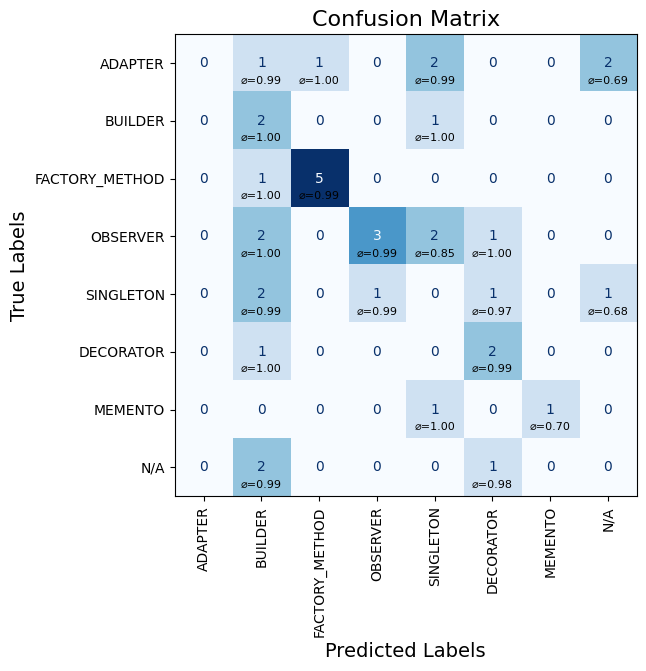

In [1097]:
epm.compute_cm( true_labels, pred_labels, pred_scores, labels=pattern_types )

In [1091]:
raise ValueError

ValueError: 

In [ ]:
matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
example_gidx = -1
source_iter = iter( groups_by_source )
for _ in range( 21 ):
    example_gidx = next( source_iter )
print( f"Should be: {dataset.get_source_patterns()[ example_gidx ]}" )
for pattern_type, score in misc_utils.sort_dict_by_value(
        source_preds[ example_gidx ], reverse=True ).items():
    print( f"{pattern_type}: {score:.3}" )
for pattern_type, idxs in groups_by_source[ example_gidx ].items():
    for idx in idxs[ :1 ]:
        source = sources[ idx ]
        query = queries[ idx ]
        pred = preds[ idx ]
        meta = metas[ idx ]
        print( meta )
        source_type = meta.get( "source_type" )
        gidx = meta.get( "gidx" )
        p_w = meta.get( "pred_w", 1.0 )
        combined, node_colors, edge_colors = graph_utils.combine_normalized(
            source, query, matching_colors=matching_colors )
        plot_utils.plot_graph( combined,
                               title=f"#{gidx} ({source_type}): query #{idx} ({pattern_type}) [p={pred:.2}][p_w={p_w:.2}]",
                               nodeLabels=graph_utils.get_node_labels( combined ),
                               nodeColors=node_colors, edgeColors=edge_colors )